In [ ]:
!pip install -q tensorflow==2.10.1

import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

from keras.models import Sequential
from keras.layers import Dense, Flatten

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

     |████████████████████████████████| 578.1 MB 28 kB/s 
     |████████████████████████████████| 438 kB 60.1 MB/s 
     |████████████████████████████████| 5.9 MB 35.9 MB/s 
     |████████████████████████████████| 1.7 MB 53.4 MB/s 
2.10.1


In [ ]:
#Importing dataset in \content folder
!unzip /content/training_dataset_homework1.zip
!unzip /content/training_data_final_rotated.zip

In [ ]:
# Download and import visualkeras library
!pip install visualkeras
import visualkeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 989 kB 33.1 MB/s 


In [ ]:
#library for splitting folders
!pip install split-folders
import splitfolders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import shutil

base_directory = '/content/training_data_final'
base_directory_rotated = '/content/training_data_final_clean_sp1ruotate/training_data_final_clean'

#Splitting our dataset into training (clean images) and validation (all images)

# Split with a ratio.
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
splitfolders.ratio(base_directory, output="data_splitted", ratio=(.7, .3, .0), group_prefix=None, move=False)
splitfolders.ratio(base_directory_rotated, output="data_rotated", ratio=(1, 0, 0), group_prefix=None, move=False)

dirs_rotated = []
dirs_val = []
dirs_test = []
for dirname, _, filenames in os.walk(base_directory_rotated):
    for filename in filenames:
        dirs_rotated.append(dirname.split('/')[-1] + "/" + filename)   

for dirname, _, filenames in os.walk('data_splitted/val'):
    for filename in filenames:
        dirs_val.append(dirname.split('/')[-1] + "/" + filename)
for dirname, _, filenames in os.walk('data_splitted/test'):
    for filename in filenames:
        dirs_test.append(dirname.split('/')[-1] + "/" + filename)
        
for dir_rotated in dirs_rotated:
    if (dir_rotated in dirs_val) or (dir_rotated in dirs_test):
        if os.path.exists("data_rotated/train/" + dir_rotated):
            os.remove("data_rotated/train/" + dir_rotated)

Copying files: 3542 files [00:00, 5541.69 files/s]
Copying files: 3595 files [00:00, 7710.68 files/s]


In [ ]:
# Images are divided into folders, one for each class. 
# If the images are organized in such a way, we can exploit the 
# ImageDataGenerator to read them from disk.
from tensorflow.keras.preprocessing.image import ImageDataGenerator

training_dir = '/content/data_rotated/train'
validation_dir = '/content/data_splitted/val'
test_dir = '/content/data_splitted/test'


# Create an instance of ImageDataGenerator for training
train_data_gen = ImageDataGenerator()

noaug_train_data_gen = ImageDataGenerator() # rescale value is multiplied to the image
valid_data_gen = ImageDataGenerator()
test_data_gen = ImageDataGenerator()

# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
noaug_train_gen = noaug_train_data_gen.flow_from_directory(directory=training_dir,
                                                           target_size=(96,96),
                                                           color_mode='rgb',
                                                           classes=None, # can be set to labels
                                                           class_mode='categorical',
                                                           batch_size=32,
                                                           shuffle= False
                                                           )

# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
# Create an instance of ImageDataGenerator with Data Augmentation
aug_train_data_gen = ImageDataGenerator(rotation_range=0.1,
                                        height_shift_range=40,
                                        width_shift_range=40,
                                        zoom_range=0,
                                        horizontal_flip=True,
                                        vertical_flip=True, 
                                        fill_mode='reflect'
                                       ) # rescale value is multiplied to the image

# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
aug_train_gen = aug_train_data_gen.flow_from_directory(directory=training_dir,
                                                       target_size=(96,96),
                                                       color_mode='rgb',
                                                       classes=None, # can be set to labels
                                                       class_mode='categorical',
                                                       batch_size=32,
                                                       shuffle= False #set to false if need to compare images
                                                       )

valid_gen = valid_data_gen.flow_from_directory(directory=validation_dir,
                                               target_size=(96,96),
                                               color_mode='rgb',
                                               classes=None, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=32,
                                               shuffle=False)
test_gen = test_data_gen.flow_from_directory(directory=test_dir,
                                              target_size=(96,96),
                                              color_mode='rgb',
                                              classes=None, # can be set to labels
                                              class_mode='categorical',
                                              batch_size=8,
                                              shuffle=False)

Found 2556 images belonging to 8 classes.
Found 2556 images belonging to 8 classes.
Found 1059 images belonging to 8 classes.
Found 8 images belonging to 8 classes.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/AN2DL

Mounted at /content/drive
/content/drive/MyDrive/AN2DL


In [ ]:
# Utility function to create folders and callbacks for training
from datetime import datetime

def create_folders_and_callbacks(model_name):

  exps_dir = os.path.join('data_augmentation_experiments')
  if not os.path.exists(exps_dir):
      os.makedirs(exps_dir)

  now = datetime.now().strftime('%b%d_%H-%M-%S')

  exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
  if not os.path.exists(exp_dir):
      os.makedirs(exp_dir)
      
  callbacks = []

  # Model checkpoint
  # ----------------
  ckpt_dir = os.path.join(exp_dir, 'ckpts')
  if not os.path.exists(ckpt_dir):
      os.makedirs(ckpt_dir)

  ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp.ckpt'), 
                                                     save_weights_only=True, # True to save only weights
                                                     save_best_only=True) # True to save only the best epoch 
  callbacks.append(ckpt_callback)

  # Visualize Learning on Tensorboard
  # ---------------------------------
  tb_dir = os.path.join(exp_dir, 'tb_logs')
  if not os.path.exists(tb_dir):
      os.makedirs(tb_dir)
      
  # By default shows losses and metrics for both training and validation
  tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir, 
                                               profile_batch=0,
                                               histogram_freq=1)  # if > 0 (epochs) shows weights histograms
  callbacks.append(tb_callback)

  # Early Stopping
  # --------------
  es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=35, restore_best_weights=True)
  callbacks.append(es_callback)

  return callbacks

In [ ]:
# free some memory if necessary
import gc
gc.collect()

153

In [ ]:
def count_files(directory):
  count = 0
  for root_dir, cur_dir, files in os.walk(directory):
      count += len(files)
  return count

In [ ]:
def get_class_weights(path):
    num_classes = 8
    num_images = count_files(path)
    elements = np.zeros(8)
    weights = np.zeros(8)

    for i in range(num_classes):
        elements[i] = count_files(path+"/Species"+str(i+1))
        weights[i] = (1 / elements[i]) * (num_images / 8.0)

    class_weight = {0: weights[0], 1: weights[1], 2: weights[2], 3: weights[3], 4: weights[4], 5: weights[5], 6: weights[6], 7: weights[7]}

    return class_weight

In [ ]:
# to perform class weight training
class_weight = get_class_weights("/content/data_rotated/train")
class_weight

{0: 1.0579470198675496,
 1: 0.902542372881356,
 2: 0.9508928571428571,
 3: 0.9287790697674418,
 4: 0.9050991501416431,
 5: 2.1300000000000003,
 6: 0.852,
 7: 0.9342105263157894}

In [ ]:
from tensorflow.keras.applications import convnext
import sys
from matplotlib import pyplot
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LayerNormalization
from keras.layers import GlobalAveragePooling2D
from keras import backend as K

# build and training onto a "with" block that allows the use of both the GPUs
# we did not use that features
base_model = convnext.ConvNeXtXLarge(
    model_name='convnext_xlarge',
    include_top=False,
    include_preprocessing=True,
    weights='imagenet',
    input_shape=(96,96,3)
)
base_model.trainable = False
for layer in base_model.layers:
    layer.trainable = False

x = tfkl.GlobalAveragePooling2D()(base_model.output)
x = tfkl.Dense(1024, activation='relu')(x)
x = tfkl.Dropout(0.4)(x)
x = tfkl.Dense(8, activation='softmax')(x)          
 
model = tfk.Model( base_model.input, x)
    
optimizer = tf.keras.optimizers.RMSprop()
model.compile(optimizer = optimizer,loss = 'binary_crossentropy',metrics = ['acc'])

model.summary()
visualkeras.layered_view(model, legend=True, spacing=20, scale_xy=10)

In [ ]:
#no aug training
epochs = 10
history = model.fit(
    x = noaug_train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    callbacks = noaug_callbacks
).history

In [ ]:
# aug training
aug_callbacks = create_folders_and_callbacks(model_name='TLNoAug')
epochs = 40

history = model.fit(
    x = aug_rotated_gen,
    epochs = epochs,
    validation_data = valid_gen,
    callbacks = aug_callbacks
).history

In [ ]:
# using class weight to balance dataset
aug_callbacks = create_folders_and_callbacks(model_name='TLAug')
epochs = 20

history = model.fit(
    x = aug_rotated_gen,
    epochs = epochs,
    validation_data = valid_gen,
    callbacks = aug_callbacks,
    class_weight = class_weight
).history

In [ ]:
# Save best epoch model
model.save("data_augmentation_experiments/TL")

In [ ]:
model = tfk.models.load_model('/content/drive/MyDrive/AN2DL/data_augmentation_experiments/TL')

In [ ]:
#tuning phase
for layer in model.layers:
    layer.trainable = True

model.summary()

In [ ]:
#first training with fine tuning using 1e-4 learning rate with adam

from keras import backend as K

optimizer = tf.keras.optimizers.Adam()
K.set_value(optimizer.learning_rate, 1e-4)
model.compile(optimizer = optimizer,loss = 'binary_crossentropy',metrics = ['acc'])
noaug_callbacks = create_folders_and_callbacks(model_name='Test submit')
history = model.fit(
    x = aug_rotated_gen,
    epochs = 30,
    validation_data = valid_gen,
    callbacks = noaug_callbacks,
    class_weight = class_weight
).history

In [ ]:
#using now 1e-5 fine learning rate
K.set_value(optimizer.learning_rate, 1e-5)
model.compile(optimizer = optimizer,loss = 'binary_crossentropy',metrics = ['acc'])
noaug_callbacks = create_folders_and_callbacks(model_name='Test submit')
history = model.fit(
    x = aug_rotated_gen,
    epochs = 30,
    validation_data = valid_gen,
    callbacks = noaug_callbacks,
    class_weight = class_weight
).history

In [ ]:
# Save best epoch model
model.save("data_augmentation_experiments/FT")

In [ ]:
labels = ['Species1',
          'Species2',
          'Species3',
          'Species4',
          'Species5',
          'Species6',
          'Species7',
          'Species8']

34/34 [==============================] - 15s 309ms/step
Confusion Matrix
[[ 55   0   0   0   0   0   0   0]
 [  2 152   0   0   0   1   3   1]
 [  0   0 154   0   0   0   0   0]
 [  0   1   5 144   2   0   0   1]
 [  0   0   3   4 152   0   0   0]
 [  1   1   0   0   0  64   0   0]
 [  0   0   0   0   0   0 160   1]
 [  6   3   1   0   0   0   1 141]]
Classification Report
              precision    recall  f1-score   support

    Species1       0.86      1.00      0.92        55
    Species2       0.97      0.96      0.96       159
    Species3       0.94      1.00      0.97       154
    Species4       0.97      0.94      0.96       153
    Species5       0.99      0.96      0.97       159
    Species6       0.98      0.97      0.98        66
    Species7       0.98      0.99      0.98       161
    Species8       0.98      0.93      0.95       152

    accuracy                           0.97      1059
   macro avg       0.96      0.97      0.96      1059
weighted avg       0.97     

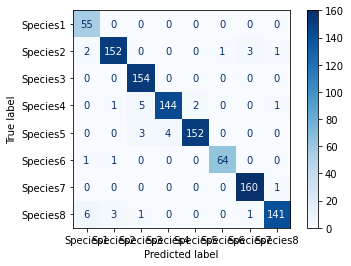

In [ ]:
#Confusion Matrix and Classification Report
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

Y_pred = model.predict(valid_gen)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(valid_gen.classes, y_pred))
print('Classification Report')
print(classification_report(valid_gen.classes, y_pred, target_names=labels))

cm = confusion_matrix(valid_gen.classes, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

disp.plot(cmap=plt.cm.Blues)
plt.show()